In [204]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor, plot_importance
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import r2_score
from sklearn import set_config
from scipy.stats import normaltest
import optuna
import re
import joblib

%matplotlib inline
sns.set_style('darkgrid')
set_config(transform_output = "pandas")
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Предисловие.

Перед Вами проект версии 2.0.

Когда первая версия проекта была готова приблизительно на 70-80%, я понял, что работу нужно переписывать. Конкретно это касается блока с очисткой данных: я понял, что нужно несколько изменить структуру глав, а также то, что при очистке данных нужно придерживаться совершенно иной стратегии. 

В ходе повествования я иногда буду забегать вперед, некоторые предпринимаемые мною действия, возможно, будут казаться нелогичными и не вытекающими напрямую из предыдущих действий. Действительно, некоторая доля моих рассуждений и умозаключений осталась за кадром, в черновой версии работы, однако все места, в которых предпосылки моих действий могут быть не ясны, я постораюсь сопроводить максимально подробными пояснениями.

# 0. Загрузка данных.

In [84]:
df = pd.read_csv('data.csv')
df.head()

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


# 0.5. Корректировка условия задачи.

Начну с того, что обращу Ваше внимание на следующий факт: в таблице представлены записи об объектах, принадлежащих к разным классам, а именно: жилье на продажу, жилье в аренду и земельные участки на продажу.

Я утверждаю, что объекты данных классов нельзя рассматривать в совокупности и каждый из названных мною классов требует построения отдельной модели машинного обучения по следующим причинам:
1. Формирование цены на жилье в аренду и на продажу производится по разным принципам. Очевидно, что цена на один и тот же объект недвижимости с одними и теми же характеристиками будет различаться на 2 порядка в зависимости от того, продается ли этот объект или сдается в аренду с помесячной оплатой. За причисление объекта недвижимости к множеству объектов, сдающихся в аренду, в нашем датафрейме будет отвечать одна бинарная переменная, которой будет не хватать для того, чтобы модель научилась различать принципиальную разницу между формированием цены на продажу и аренду недвижимости.
2. Земельные участки и жилье характеризуются разными признаками. В нашем датафрейме будут такие признаки как "кол-во ванных комнат", "кол-во спален", "кол-во этажей", "жилая площадь", "год постройки" и т.д. Все эти признаки у земельных участков отсутствуют. Нам придется приравнивать их к нулю, чтобы не погрешить против истины (хотя что такое "нулевой год постройки земельного участка"?), но подобные записи будут серьезно искажать работу модели - модель точно так же как и в случае с ценой на аренду не сможет различать принципиальную разницу между жилыми помещениями и земельными участками.

В связи с вышеизложенным, я предлагаю рассматривать в данном проекте исключительно те объекты недвижимости, которые мы можем причислить к классу "жилье на продажу", записи же об остальных объектах я предлагаю удалить - и сделать это прямо сейчас.

In [85]:
rent = ['Apartment for rent', 'Condo for rent', 'for rent']
land = ['Land', 'lot/land']
df = df[(~df['status'].isin(rent)) & (~df['propertyType'].isin(land))]

# 1. Очистка данных.

## 1.1. Первичный осмотр данных.

Посмотрим на объем нашего датафрейма, типы данных и кол-во пропусков.

In [86]:
df.shape

(345287, 18)

In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 345287 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        305370 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  310554 non-null  object
 3   street        345287 non-null  object
 4   baths         266219 non-null  object
 5   homeFacts     345287 non-null  object
 6   fireplace     102029 non-null  object
 7   city          345278 non-null  object
 8   schools       345287 non-null  object
 9   sqft          321202 non-null  object
 10  zipcode       345287 non-null  object
 11  beds          282932 non-null  object
 12  state         345287 non-null  object
 13  stories       223890 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   39886 non-null   object
 16  MlsId         278608 non-null  object
 17  target        342827 non-null  object
dtypes: object(18)
memory usage: 5

In [88]:
df.describe()

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
count,305370,4181,310554,345287,266219,345287,102029,345278,345287,321202,345287,282932,345287,223890,24942,39886,278608,342827
unique,155,1,1278,308664,227,307784,1651,1915,270884,24927,4476,1180,38,342,24907,2,208878,42636
top,for sale,Yes,single-family home,Address Not Disclosed,2 Baths,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",yes,Houston,"[{'rating': [], 'data': {'Distance': [], 'Grad...",0,33131,3 Beds,FL,1.0,No MLS#,yes,NO MLS,"$225,000"
freq,135717,4181,91989,632,51981,7168,49299,23314,3089,948,1549,52302,102798,66151,3,28370,23,1286


In [89]:
df.isna().mean().sort_values(ascending=False)

private pool    0.987891
mls-id          0.927764
PrivatePool     0.884485
fireplace       0.704510
stories         0.351583
baths           0.228992
MlsId           0.193112
beds            0.180589
status          0.115605
propertyType    0.100592
sqft            0.069754
target          0.007125
city            0.000026
zipcode         0.000000
state           0.000000
schools         0.000000
homeFacts       0.000000
street          0.000000
dtype: float64

Итак, что же мы видим:
1. Во-первых, в глаза бросается то, что все признаки имеют тип данных "object", хотя, очевидно, некоторые из них должны быть числовыми: "beds", "sqft", "target" и т.п.
2. Во-вторых, видно, что некоторые категориальные переменные имеют неправдободобно большое кол-во уникальных значений: 155 типов статуса продажи, 1278 (!) типов недвижимости и т.п.
3. В-третьих, признаки "homeFacts" и "schools" представляют собой сложные списки и словари, которые придется распаковывать.
4. В-четвертых, в данных много пропусков.
5. В-пятых, имеются признаки-дубликаты.
6. И самое интересное, - в шестых, - это наличие неполных дубликатов строк, т.е. записей об одном и том же объекте, которые при этом могут отличаться друг от друга по нескольким признакам. Я приведу пример:

In [90]:
df[(df['MlsId'] == 'O5822127') | (df['mls-id'] == 'O5822127')]

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
109613,foreclosure,NaN,single-family home,16616 Brigadoon Dr,3 Baths,"{'atAGlanceFacts': [{'factValue': '1983', 'fac...",NaN,Tampa,"[{'rating': ['5/10', '8/10', '8/10'], 'data': ...","1,120 sqft",33618,2 Beds,FL,2.0,NaN,NaN,O5822127,"$135,900"
112229,Auction - Active,NaN,NaN,16616 Brigadoon Dr #1,NaN,"{'atAGlanceFacts': [{'factValue': '1983', 'fac...",NaN,TAMPA,"[{'rating': ['8', '8', '5'], 'data': {'Distanc...","1,120",33618,NaN,FL,Two,NaN,NaN,O5822127,"135,900"
350660,For sale,NaN,Condo,16616 Brigadoon Dr # 1,Bathrooms: 3,"{'atAGlanceFacts': [{'factValue': '1983', 'fac...",NaN,Tampa,"[{'rating': ['8/10', '8/10', '5/10'], 'data': ...","Total interior livable area: 1,120 sqft",33618,2 bd,FL,2.0,O5822127,NaN,NaN,"$141,800"


Мы видим, что о данном объекте имеются три записи, в которых отличаются значения в признаках "status", "propertyType", "baths" и даже "target". Более того, есть случаи, в которых один и тот же ID приписан двум разным объектам (адреса не совпадают).

Итак, нам предстоит очистить данные. Начнем.

## 1.2. Удаление дубликатов строк по MLS-ID.

Когда я писал первую версию работы, то у меня была идея объединить информацию из этих дубликатов, чтобы уменьшить кол-во пропусков. Например, был такой концепт: рассмотреть каждое подмножество неполных дубликатов, по каждому признаку составить словарь всех значений (например, через Counter()), убрать из словарей значения NaN, а из оставшихся значений выбрать то, которое встречается наибольшее кол-во раз (или случайным образом, если частота их появления одинакова).

Первая проблема состояла в том, что один и тот же ID может быть присвоен двум различным объектам недвижимости. Тогда появилась мысль идентифицировать объект по совокупности признаков ID + адрес. Однако идентифицировать дома таким образом оказалось очень тяжело: адреса плохо структурированы и один и тот же адрес может иметь множество различных написаний. Я начал думать, как исправить эту ситуацию, и заметил, что если разным объектам присвоен один и тот же ID, то эти объекты, как правило, находятся в разных штатах. Случаев, когда ID оказался приписан двум разным объектам, оказалось более 500 (и это я еще не все нашел - мне пришлось прекратить поиск, так как он слишком сильно затянулся по времени), как эффективно организовать зануление части подобных ID - непонятно (возможно, точно так же подсчетом через Counter() и голосованием).

Вторая же (и основная) проблема оказалась в том, что рассматривать все подмножества частичных дубликатов придется, по всей видимости, в цикле: циклу придется выполнить несколько десятков тысяч итераций, на каждой итерации выполняя нетривиальный код. По приблизительным подсчетам, выполнение такого цикла займет никак не менее 10 часов (по крайней мере, на моей машине).

В общем и целом, задачу объединения неполных дубликатов строк мне решить не удалось, так что я предлагаю начать с удаления этих дубликатов и признаков "MlsId" и "mls-id". Мы потеряем часть информации, однако в ходе работы я вывел некоторое эмпирическое правило: потеря информации не так страшна, как ее серьезное искажение (ведь отсутствующая информация не путает модель, а искаженная - путает). Этим правилом я буду часто пользоваться в дальнейшей работе.

In [91]:
df.loc[df['mls-id'].isna(), 'mls-id'] = df['MlsId']
df = df.drop_duplicates('mls-id')
df = df.drop(columns=['MlsId', 'mls-id'])
df.shape

(224994, 16)

Итак, дубликаты составляли приблизительно треть таблицы. Получившиеся в итоге 225 тысяч строк - это более-менее точный истинный размер нашего датасета.

## 1.3. Очистка категориальных признаков.

В первой версии работы я старался производить очистку данных наиболее мягким и аккуратным образом, однако разобраться в гигантском кол-ве категорий многих признаков оказалось невозможным, а результат такой работы серьезно искажал данные. Более же грубая очистка данных, предпринятая мною в этой версии проекта, привела к значительному улучшению метрик.

### 1.3.1. Статус продажи.

Как уже было замечено ранее, признак "status" имеет 155 уникальных категорий. Нам необходимо понять, что эти категории означают и как нам их сгруппировать.

Итак, какую же информацию несут категории данного столбца? На самом деле, столбец этот является смешанным и информация имеет разнородный характер (подобная структура столбцов будет нам часто попадаться далее):
1. Во-первых, информация о том, на каком этапе находится сделка: предложение о покупке еще не сделано; предложение сделано, но не принято продавцом; предложение сделано и принято продавцом, но договор еще не заключен и т.д.
2. Во-вторых, информация об условиях для совершения сделки: дополнительные требования к продавцу или покупателю, возможность проведения инспекции, условия выхода из сделки и т.д.
3. И в-третьих, способ продажи: прямая продажа, аукцион, сдача в аренду и т.д.

Итак, мы могли бы выделить всю вышеуказанную информацию из данного признака и разместить ее по трем разным столбцам. Но так как мы не хотим делать слишком много работы, то я предлагаю подумать и найти причину, согласно которой часть этой информации будет для нас бесполезна.

Крайне сомнительно, что этап соверешения сделки и условия совершения сделки влияют на цену, не говоря уже о том, что большую часть записей с категориями, содержащими подобную информацию, мы удалим в ходе очистки.

А что касается способа продажи, то тут уже сомнений быть не может: очевидно, что при прямой продаже в среднем выставляется более высокая цена; при аукционе начальная цена будет ниже (хотя аукционы, конечно же, бывают разные, бывают и с понижением цены, но данный аспект в задаче не обговаривается) и т.п. Вот эта информация нам и нужна.

В ходе очистки данных я часто буду использовать один прием - удаление всех запсей о категориях, к которым причислено менее 100 объектов. Да, так мы потярем часть данных, но, как я сказал ранее, избежим искажений, так как категорий очень много и точная их группировка невозможна.

In [92]:
# удаляем записи с категориями, к которым причислено менее 100 объектов
status_vc = df['status'].value_counts()
status_100 = status_vc[status_vc >= 100].index
df = df[(df['status'].isin(status_100)) | (df['status'].isna())]

# удаляем записи со значением статуса "Price Change"
df = df[df['status'] != 'Price Change']

Оставшиеся записи сгруппируем по следующим категориям:
1) "action" - прямая продажа;
2) "foreclosure" - переход недвижимости банку за неуплату кредита;
3) "unknown" - все то, что мы не можем с уверенностью приписать любой другой категории, а также пропуски.

In [93]:
# выделяем категории
foreclosure = ['foreclosure', 'Foreclosure']
unknown = ['Pending', 'New construction', 'P', 'New']

df.loc[df['status'].isin(foreclosure), 'status'] = 'foreclosure'
df.loc[(df['status'].isin(unknown)) | (df['status'].isna()), 'status'] = 'unknown'

df.loc[(~df['status'].isin(['foreclosure', 'unknown'])), 'status'] = 'action'

# смотрим на результаты
df['status'].value_counts(normalize=True)

status
action         0.871612
unknown        0.118422
foreclosure    0.009966
Name: proportion, dtype: float64

Признак большей частью состоит из одной категории, однако я не вижу оснований его удалять. Возможно, признак окажется информативным.

### 1.3.2. Бассейн.

Признаки, содержащие информацию о наличии бассейна, почти полностью состоят из пропусков. Даже при их объединении, получившийся признак будет заполнен процентов на 15. Предлагаю сразу удалить признаки.

In [94]:
df = df.drop(columns=['private pool', 'PrivatePool'])

### 1.3.3. Тип объекта недвижимости.

В данный столбец попал ряд категорий, содержащих информацию о кол-ве этажей. Я предлагаю выделить их в столбец "stories_2", после чего обрабатать остальные категории. Столбцы-дубликаты мы объединим позже.

Во всех случаях, когда дискретные объекты будут иметь дробные значения, я буду округлять эти значения, даже если они могут иметь смысл (так, дом в 1.5 этажа - вполне допустимое понятие), во избежание путаницы и лишней мороки.

In [95]:
# для начала переименуем столбец
df = df.rename(columns={'propertyType': 'property_type'})

# создаем столбец "stories_2"
df['stories_2'] = np.nan

# выделяем паттерны поиска
pattern_1_story = r'(1|one) story'
pattern_2_stories = r'(2|two)[-\s]stor(y|ies)|1 1/2 Story'

to_1_story = df['property_type'].str.contains(pattern_1_story, na=False,
                                              case=False)
to_2_stories = df['property_type'].str.contains(pattern_2_stories, na=False,
                                                case=False)
to_3_stories = '3 Story'

# присваиваем значения
df.loc[to_1_story, 'stories_2'] = 1
df.loc[to_2_stories, 'stories_2'] = 2
df.loc[df['property_type'] == to_3_stories, 'stories_2'] = 3

# убираем категории, которые невозможно точно интерпретировать
story_unclear = 'Detached, One Story, Two Story'
df.loc[df['property_type'] == story_unclear, 'stories_2'] = np.nan

C:\Users\drull\AppData\Local\Temp\ipykernel_10360\205860050.py:11: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.

C:\Users\drull\AppData\Local\Temp\ipykernel_10360\205860050.py:13: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.



Теперь займемся типами недвижимости.

В сведениях о данных, прилагающихся к данному заданию, приведен список типов недвижимости, однако в этом списке смешаны категории, относящиеся к двум различным понятиям: тип недвижимости (отдельный дом, таунхаус и т.п.) и стиль (тюдор, европейский и т.п.). Очевидно, что тип недвижимости и стиль - это разные понятия, так как тип указывает на функциональные особенности недвижимости, а стиль - на художественное оформление.

Мы не будем выделять стиль в отдельный признак, так как он указан в крайне редких случаях (менее 10%): такой признак все равно придется удалить.

Что же касается типа недвижимости, то мы будем выделять следующие категории:
1) "single-family" - односемейный дом;
2) "condo" - кондоминиум;
3) "townhouse" - таунхаус;
4) "co-op" - кооператив;
5) "multi-family" - многосемейный дом;
6) "apartment" - апартаменты;
7) "unknown" - все то, что мы не можем с уверенностью приписать любой другой категории, а также пропуски.

In [96]:
# удаляем записи с категориями, к которым причислено менее 100 объектов
property_type_vc = df['property_type'].value_counts()
property_type_100 = property_type_vc[property_type_vc >= 100].index
df = df[(df['property_type'].isin(property_type_100)) | (df['property_type'].isna())]

# выявляем все категории, кроме "unknown"
patterns = ['condo', 'townhouse|attached|plex', 'co-?op', 'multi[-\s]family',
            'detached|single[-\s]family|bungalow|cottage', 'apartment']
types = ['condo', 'townhouse', 'co-op', 'multi-family', 'single-family',
         'apartment']

for p, t in zip(patterns, types):
    df.loc[df['property_type'].str.contains(p, na=False, case=False), 'property_type'] = t

# все, что не вошло в другие категории, помещаем в "unknown"
df.loc[(~df['property_type'].isin(types)), 'property_type'] = 'unknown'

# смотрим на результаты
df['property_type'].value_counts(normalize=True)

property_type
single-family    0.548973
unknown          0.182875
condo            0.163882
townhouse        0.051631
multi-family     0.040262
co-op            0.009845
apartment        0.002532
Name: proportion, dtype: float64

Результат вполне удовлетворительный.

### 1.3.4. Адрес.

Изначальная задумка была такой: прогнать адреса через geopy, получить координаты недвижимости и как-нибудь ими проманипулировать, навпример, высчитать расстояние от центра города до объекта. Но, как это часто бывает, прекрасная идея разбилась о жестокую реальность.

Дело в том, что адресов у нас очень много. Тяжело точно сказать, сколько у нас уникальных адресов, так как они плохо структурированы (и, по классике, столбец содержит много лишних категорий), но более-менее точно можно сказать, что их приблизительно 200 тысяч. Так вот, бесплатные геокодеры по типу Nominatim позволяют отправлять не более одного запроса в секунду, что значит, что мне потребуется 55 часов непрерывной работы компьютера, чтобы получить координаты всех объектов (не говоря уже о том, что меня, скорее всего, забанять по IP после первой 1000 запросов за DoS-атаку), а пользоваться платными геокодерами я, разумеется, не собираюсь.

К сожалению, нам ничего не остается, кроме как удалить этот крайне полезный столбец.

In [97]:
df = df.drop(columns='street')

### 1.3.5. Камин.

In [98]:
df['fireplace'].isna().mean()

0.6890679731678839

Пропуски составляют 69% - удаляем.

In [99]:
df = df.drop(columns='fireplace')

### 1.3.6. Город.

На просторах интернета я нашел [таблицу](https://simplemaps.com/data/us-cities), содержащую информацию о городах США. В частности, таблица содержит данные, которые могут быть нам крайне полезны: население города, плотность населения, координаты города, а также некий ранг, указывающий на важность города (что бы это ни значило).

Опять же, из-за того, что данные крайне грязные и название одного и того же города может быть указано несколькими разными способами, мы потеряем часть записей.

In [100]:
# приводим название городов к единому регистру
df['city'] = df['city'].str.title()

# загружаем таблицу и выделяем необходимы столбцы
cities = pd.read_csv('uscities.csv')
cities = cities[['city', 'state_id', 'lat', 'lng', 'population', 'density',
                 'ranking']]

# объединяем таблицы
df = pd.merge(df, cities, how='inner', left_on=['city', 'state'],
              right_on=['city', 'state_id']).drop(columns='state_id')

# удаляем столбец "city"
df = df.drop(columns='city')

## 1.4. Создание числовых признаков.

### 1.4.1. Ванные комнаты.

В большинстве своем категории данного столбца содержат числа. Иногда эти числа дробные (что бы это могло значить?). Целая часть от дробной иногда отделяется точкой, а иногда запятой (что, впрочем, не является большой проблемой). Однако есть категории, которые сложно интерпретировать, например такие как "2-1 / 2-1 / 1-1 / 1-1" или "116 / 116 / 116". Такие категории мы заменим на NaN.

In [101]:
# убираем категории, которые невозможно точно интерпретировать
baths_unclear = ['—', '-- baths', '~', '0 / 0', '1 / 1 / 1 / 1',
                 '1-0 / 1-0 / 1', '3-1 / 2-2',
                 'Bathrooms: SemiMod', 'Sq. Ft. ']
to_nan = df['baths'].isin(baths_unclear)
df.loc[to_nan, 'baths'] = np.nan

# выделим числа
df['baths'] = df['baths'].str.findall(r'\d+[.,]?\d*').explode()

# заменим запятые на точки, преобразуем строки в числа и округлим до
# ближайшего целого
df['baths'] = np.round(df['baths'].str.replace(',', '.').astype('float32'))

Пока что не будем обращать внимание на неправдободобные значения - ими мы займемся позже.

### 1.4.2. Площадь в футах.

Действовать будем по той же схеме, но с небольшим изменением: разделяющая запятая в данных записях отделяет не дробную часть числа от целой, а разряд тысяч от разряда единиц, так что запятую мы будем просто удалять. А в остальном все так же.

In [102]:
# убираем категории, которые невозможно интерпретировать
sqft_unclear = ['--', '-- sqft']
to_nan = df['sqft'].isin(sqft_unclear)
df.loc[to_nan, 'sqft'] = np.nan

# выделяем числа
df['sqft'] = df['sqft'].str.findall(r'\d+[.,-]?\d*[.,-]?\d*').explode().str.replace(',', '').astype('float32')

### 1.4.3. Спальни.

Признак "beds" представлен большим кол-вом категорий, указывающих не на кол-во спален, а на площадь: эти категории содержат слова "acres" и "sqft". Однако стоит заметить, что акр - это земельная мера (как гектар). В действительности мы не можем с точностью установить, площадь чего именно указана в этих категориях: жилой площади или земельного участка. Возможно даже, что часть категорий относится к одному, а часть - к другому. Я предпочту поостеречься и не рассматривать данные категории.

Теперь переформатируем признак "beds" в числовой вид.

In [103]:
# удалим все категории, связанные с площадью
df.loc[df['beds'].str.contains('acre|sqft', na=False), 'beds'] = np.nan

# убираем категории, которые невозможно интерпретировать
beds_unclear = [' ', '-- bd', '-- sqft', '2 Baths, 3 or More Bedrooms',
                '1 Bath, 3 or More Bedrooms, Cable TV Available, Dining Room, Eat-In Kitchen, Living Room, Range/Oven, Refrigerator',
                'Bath', 'Baths']
to_nan = df['beds'].isin(beds_unclear)
df.loc[to_nan, 'beds'] = np.nan

# несколько категорий обработаем вручную
two_beds = ['1 Bath, 2 Bedrooms, Living Room, Range/Oven, Refrigerator',
            '1 Bath, 2 Bedrooms']
df.loc[df['beds'].isin(two_beds), 'beds'] = 2

# выделяем числа
df['beds'] = df['beds'].str.findall(r'\d+[.,]?\d*').explode().astype('float32')

### 1.4.4. Этажи.

В данный столбец попали категории, содержащие информацию о типе объекта недвижимости.

In [104]:
# создаем и заполняем столбец "propertyType_2"
df['propertyType_2'] = np.nan

patterns = ['Condo', 'Detached|Bungalow|Cottage', 'Townhouse|plex']
types = ['condo', 'single-family', 'townhouse']

for p, t in zip(patterns, types):
    df.loc[df['stories'].str.contains(p, na=False), 'propertyType_2'] = t
    
# объединяем столбцы
df.loc[df['property_type'].isna(), 'property_type'] = df['propertyType_2']
df = df.drop(columns='propertyType_2')

Далее создаем числовой признак, аналогично тому как мы это делали раньше.

In [105]:
# убираем категории, которые невозможно точно интерпретировать
stories_unclear = ['1 Level, 1.5 Level', '1 Level, 2 Level', '1 Story, 2 Story',
                   '1-2 Stories', '1-2 Stories, 3-4 Stories', '2 Or More Stories',
                   '3 - 5 Stories', '3-4 Stories', 'Townhouse-2 Story, T3-Townhouse 3+ Stories',
                   '1.5 Level, Site Built, Tri-Level', '3+', '3+ Story',
                   '6+ Stories', 'Condo 5+ Stories', 'T3-Townhouse 3+ Stories']
to_nan = df['stories'].isin(stories_unclear)
df.loc[to_nan, 'stories'] = np.nan
                   
# несколько категорий обработаем вручную
one_story = ['1, 1', 'Ground Level, One', 'One', 'One Level', 'One Story',
             'Ranch/1 Story']
two_stories = ['1 1/2 Levels', '1 1/2 Story', '1.5, 2', '2 Story or 2 Level',
               'Bi-Level', 'Ground Level, Split Level, Two',
               'Ground Level, Two', 'Multi/Split, Two', 'One and One Half',
               'Other, Two, Multi/Split', 'Split Entry (Bi-Level)',
               'Two', 'Two Stories', 'Two, Multi/Split']
three_stories = ['Multi Level, Tri Level', 'Site Built, Tri-Level',
                 'Split Foyer, Tri-Level', 'Tri Level', 'Tri/Multi Level']

for i, cat in enumerate([one_story, two_stories, three_stories]):
    df.loc[df['stories'].isin(cat), 'stories'] = i+1
                   
# присвоим значение NaN всем категориям, которые не содержат чисел
to_nan = ~df['stories'].str.contains(r'\d', na=True)
df.loc[to_nan, 'stories'] = np.nan
                   
# выделяем числа
df['stories'] = df['stories'].str.findall(r'\d+[.,]?\d*').explode().astype('float32')

# объединяем признаки "stories" и "stories_2"
df.loc[df['stories_2'].isna(), 'stories_2'] = df['stories']
df = df.drop(columns='stories')
df = df.rename(columns={'stories_2': 'stories'})

### 1.4.5. Цена.

In [106]:
# выделяем числа
df['target'] = df['target'].str.findall(r'\d+[.,]?\d*[.,]?\d*').explode().str.replace(',', '').astype('float32')

## 1.5. Распаковка составных признаков.

### 1.5.1. Факты о доме.

Данные в столбце "homeFacts" упакованы довольно сложным образом, однако мы достаточно легко можем привести данные в вид списка словарей.

In [107]:
df['homeFacts'] = df['homeFacts'].apply(lambda x: list(eval(x).values())[0])

Каждый словарь содержит 2 ключа: "factValue" (значение признака) и "factLabel" (название признака). Всего представлено 7 признаков:
1) год постройки; 
2) год реконструкции;
3) система отопления;
4) система охлаждения;
5) парковка;
6) размер земельного участка;
7) цена за 1 кв. фут.

Мы можем привести данные списки к более удобному и логичному виду: словари, в котором ключами будут названия признаков, а значениями - значения признаков. Из этих словарей мы и составим новые столбцы для нашего датафрейма.

In [108]:
# переформатируем списки словарей в словари
def to_dict(entry):
    '''Функция для обработки признака "homeFacts": принимает список словарей
    и возвращает словарь.'''
    d = dict()
    for index, value in enumerate(entry):
        d[value['factLabel']] = value['factValue']
    return d

df['homeFacts'] = df['homeFacts'].apply(to_dict)

# создаем новые столбцы на основе получившихся словарей
cols = ['built_year', 'remodeled_year', 'heating', 'cooling', 'parking',
        'lotsize', 'price/sqft']
keys = ['Year built', 'Remodeled year', 'Heating', 'Cooling', 'Parking',
        'lotsize', 'Price/sqft']

for col, key in zip(cols, keys):
    df[col] = df['homeFacts'].apply(lambda x: x[key])
    
# удаляем столбец "homeFacts"
df = df.drop(columns='homeFacts')

#### 1.5.1.1. Год постройки.

In [109]:
# убираем категории, которые невозможно точно интерпретировать
to_nan = ['', 'No Data', '559990649990', '1']
df.loc[df['built_year'].isin(to_nan), 'built_year'] = np.nan

# переводим признак в числовой тип
df['built_year'] = df['built_year'].astype('float32')

#### 1.5.1.2. Год реконструкции.

In [110]:
# убираем категории, которые невозможно точно интерпретировать
to_nan = ['', '0']
df.loc[df['remodeled_year'].isin(to_nan), 'remodeled_year'] = np.nan

# переводим признак в числовой тип
df['remodeled_year'] = df['remodeled_year'].astype('float32')

#### 1.5.1.3. Система отопления.

Категории содержат в себе разнородную информацию: указание на тип системы отопления и на тип топлива. Мы оставим только информацию о типе системы.

In [111]:
# удаляем записи с категориями, к которым причислено менее 100 объектов
heating_vc = df['heating'].value_counts()
heating_100 = heating_vc[heating_vc >= 100].index
df = df[df['heating'].isin(heating_100)]

# выделяем признаки
baseboard = ['Baseboard', 'Baseboard, Forced air']
forced_air = ['Forced Air, Gas', 'Forced Air, Natural Gas', 'Forced Air',
              'Forced air', 'Forced air, Heat pump', 'Forced Air Heating',
              'Forced air, Other', 'Forced air, Stove']
furnace = [', Gas Hot Air/Furnace', ', Gas Hot Air/Furnace, MultiZone Heat',
           'Central Air', 'Central Air, Ceiling Fan(s)', 'Central Furnace',
           'Central Air Conditioning', 'Central Air, Central Heat']
heat_pump = ['Central Electric, Heat Pump', 'Central, Electric, Heat Pump',
             'Electric, Heat Pump', 'Heat Pump', 'Heat pump',
             ', Heat Pump - Heat', 'Heat Pump(s)', 'Central, Heat Pump']
radiant = ['Radiant']
wall = ['Wall', 'Wall Heater']

patterns = [baseboard, forced_air, furnace, heat_pump, radiant, wall]
types = ['baseboard', 'forced_air', 'furnace', 'heat_pump', 'radiant', 'wall']


for p, t in zip(patterns, types):
    df.loc[df['heating'].isin(p), 'heating'] = t

# выделяем признак "unknown"
df.loc[(~df['heating'].isin(types)), 'heating'] = 'unknown'

# смотрим на результаты
df['heating'].value_counts(normalize=True)

heating
forced_air    0.463897
unknown       0.437286
heat_pump     0.036485
furnace       0.033926
baseboard     0.013793
wall          0.010192
radiant       0.004422
Name: proportion, dtype: float64

Что ж, столбец большей частью состоит из неизвестных значений, однако же не будем спешить его удалять.

#### 1.5.1.4. Система охлаждения.

Столбец "cooling" содержит крайне мало информации, к тому же значения часто повторяют значения из столбца "heating". Данный признак предлагаю удалить.

In [112]:
df = df.drop(columns='cooling')

#### 1.5.1.4. Парковка.

Признак содержит более 2000 уникальных категорий, также содержащих разнородную информацию: о типе парковочного места и о кол-ве парковочных мест. Информация предоставлена настолько некорректно, что я не берусь очищать данный признак и предлагаю его просто удалить.

In [113]:
df = df.drop(columns='parking')

#### 1.5.1.5. Площадь земельного участка.

In [114]:
# убираем категории, которые невозможно точно интерпретировать
to_nan = ['—', '-- sqft lot', 'No Data', '']
df.loc[df['lotsize'].isin(to_nan), 'lotsize'] = np.nan

# удаляем разделяющие разряды запятые и создаем списки, в которых первый
# элемент будет числом, а второй (опциональный) будет указывать на единицу
# измерения
df['lotsize'] = df['lotsize'].str.replace(',', '').str.split(n=1)

# переводим акры в квадратные метры
def to_sqft(area):
    '''Функция для обработки признака "lotsize". Принимает список и возвращает
    число - площадь участка в квадратных футах.'''
    if isinstance(area, list):
        if len(area) == 2 and 'acre' in area[1].lower():
            return float(area[0]) * 43560
        else:
            return float(area[0])
        
df['lotsize'] = df['lotsize'].apply(to_sqft)

#### 1.5.1.6. Цена за 1 кв. фут.

In [115]:
# убираем категории, которые невозможно точно интерпретировать
to_nan = ['', 'Contact manager', 'No Data', 'No Info']
df.loc[df['price/sqft'].isin(to_nan), 'price/sqft'] = np.nan

# выделяем числа
df['price/sqft'] = df['price/sqft'].str.findall(r'\d+[.,]?\d*[.,]?\d*').explode().str.replace(',', '').astype('float32')

### 1.5.2. Школы.

В столбце "schools" хранится информация о школах. Из него мы можем получить информацию о кол-во школ, рейтинге каждой школы и ее удаленности от объекта недвижимости. Но есть один нюанс: каждая из школ обучает только с определенного класса и по определенный класс, причем диапазоны классов непостоянны. Было бы некорректно смешивать их в общее понятие "школа": близость расположения начальной школы более критична для родителей, чем близость расположения старшей, так как маленького ребенка нужно водить в школу и забирать из нее (не уверен, что система с желтыми школьными автобусами из голливудских фильмов так уж повсеместна), а ученика старших классов - нет.

Однако я не придумал, как эффективно обработать данный признак, так что мы будем рассматривать все школы как таковые. Я предлагаю выделить следующие признаки: кол-во школ, средний рейтинг школ, стандартное отклонение рейтинга школ, среднее расстояние до школ, стандартное отклонение расстояния до школ.

In [116]:
# распаковываем списки
df['schools'] = df['schools'].apply(lambda x: eval(x)[0])

# создаем столбцы "rating" и "distance"
df['rating'] = df['schools'].apply(lambda x: x['rating'].copy())
df['distance'] = df['schools'].apply(lambda x: x['data']['Distance'].copy())

# присваиваем значение NaN, если ячейка содержит пустой список
df.loc[df['rating'].map(len) == 0, 'rating'] = np.nan
df.loc[df['distance'].map(len) == 0, 'distance'] = np.nan

# создаем столбец с кол-вом школ
df['number_of_schools'] = df['rating'].map(len, na_action='ignore')

# создаем столбцы со средним рейтингом и стандартным отклонением рейтинга
def school_rating(record):
    '''Функция для обработки признака "rating". Принимает список строк и 
    возвращает список чисел'''
    if isinstance(record, list):
        rec = record.copy()
        if rec[0] == '':
            return np.nan
        for i in range(len(rec)):
            if 'NR' in rec[i] or 'None' in rec[i] or 'NA' in rec[i]:
                rec[i] = np.nan
            else:
                rec[i] = float(re.search(r'^\d+', rec[i]).group())    
        return rec
    
df['rating'] = df['rating'].apply(school_rating)
df['school_rating_avg'] = np.round(df['rating'].map(np.nanmean, na_action='ignore'), 2)
df['school_rating_std'] = np.round(df['rating'].map(np.nanstd, na_action='ignore'), 2)

# создаем столбцы со средним расстоянием и стандартным отклонением расстояния
def school_distance(record):
    '''Функция для обработки признака "distance". Принимает список строк и 
    возвращает список чисел'''
    if isinstance(record, list):
        rec = record.copy()
        if rec[0] == '':
            return np.nan
        for i in range(len(rec)):
            rec[i] = float(re.search(r'\d+[\.]?\d*', rec[i]).group())    
        return rec
    
df['distance'] = df['distance'].apply(school_distance)
df['school_distance_avg'] = np.round(df['distance'].map(np.nanmean, na_action='ignore'), 2)
df['school_distance_std'] = np.round(df['distance'].map(np.nanstd, na_action='ignore'), 2)

# удаляем лишние столбцы
df = df.drop(columns=['schools', 'rating', 'distance'])

C:\Users\drull\anaconda3\envs\python311\Lib\site-packages\pandas\core\base.py:911: RuntimeWarning:

Mean of empty slice

C:\Users\drull\anaconda3\envs\python311\Lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning:

Degrees of freedom <= 0 for slice.



## 1.6. Удаление ошибочных значений и некоторых выбросов.

Сейчас я предлагаю найти и удалить ошибочные значения в каждом столбце (то есть такие значения, которые просто не могут быть правдой), а также некоторые наиболее очевидные выбросы.

Вообще, то, что я предлагаю, нарушает метод обработки данных, так как предполагается, что поиск выбросов (как и прочие методы предобработки) выполняются исключительно на обучающей выборке, однако часть имеющихся в нашем распоряжении данных просто-напросто не соответствуют действительности, и нам нужно как-то это поправить. Производить очистку будем осторожно: удалять мы будем только те выбросы, которые явно бросаются в глаза, имеют аномальный характер и, вероятнее всего, просто не являются реальными.

К сожалению, таким образом мы не сможем найти все неадекватные записи, так как большей частью искажения состоят не в аномально больших или маленьких значениях, а в невозможной совокупности нескольких значений: например, в записи могут быть вполне допустимые значения жилой площади, кол-ва этажей, спален, ванных и т.д., однако сочетание этих значений может быть ненормальным.

Также у меня была мысль произвести кластеризацию на основе плотности и воспользоваться тем, что DBSCAN выделяет выбросы и шум в отдельный кластер, что было бы очень удобно еще и потому, что мы могли бы визуализировать результат работы нашего кластеризатора (посредством снижения размерности датасета алгоритмом t-SNE) и оценить результаты, однако при обучении модели DBSCAN Python падал, выдавая Memory Usage Error, так что от этой идеи пришлось отказаться.

Все значения, которые мы сможем точно причислить к ошибке ввода, будем заменять на NaN, в противном случае - удалять.

**Графики закоментированны, так как с ними проект не загружается на GitHub из-за большого объема файла**

### 1.6.1. Ванные комнаты.

In [1]:
# px.histogram(df['baths'], marginal='box')

Число 750 - это точно ошибка ввода. Также предлагаю считать, что кол-во ванных комнат не может быть равно нулю.

In [119]:
df.loc[df['baths'] > 100, 'baths'] = np.nan

### 1.6.2. Спальни.

In [2]:
# px.histogram(df['beds'], marginal='box')

Мы видим явные выбросы после 60.

In [121]:
df = df[~(df['beds'] > 60)]

### 1.6.3. Этажи.

In [3]:
# px.histogram(df['stories'], marginal='box')

Не возьмусь определять здесь выбросы, однако замечу, что если продается жилье, то оно не может быть в 0 этажей. В данном случае я предлагаю не удалять данные, а земенить их на NaN, так как таких записей больше 7 тысяч и вполне вероятно, что 0 и означает NaN.

In [123]:
df.loc[df['stories'] == 0, 'stories'] = np.nan

### 1.6.4. Население города.

In [4]:
# px.histogram(df['population'], marginal='box')

Не возьмусь определять выбросы.

### 1.6.5. Плостность населения города

In [5]:
# px.histogram(df['density'], marginal='box')

Виден выброс в районе 30 тысяч.

In [126]:
df = df[~(df['density'] > 20000)]

### 1.6.6. Год постройки.

In [6]:
# px.histogram(df['built_year'], marginal='box')

Колумб открыл Америку в 1492 году, так что все года, ниже названного, мы можем смело приравнивать NaN, так как это явная ошибка ввода.

In [128]:
df.loc[df['built_year'] < 1492, 'built_year'] = np.nan

### 1.6.7. Год реконструкции.

Год реконструкции не может быть меньше года постройки.

In [129]:
df.loc[df['built_year'] > df['remodeled_year'], 'remodeled_year'] = np.nan

### 1.6.8. Площадь земельного участка.

In [7]:
# px.histogram(df['lotsize'], marginal='box')

Явные выбросы после 200 млн.

Также выражу свои сомнения в том, что земельный участок может быть меньше 100 квадратных футов.

In [131]:
df = df[~(df['lotsize'] < 100) & ~(df['lotsize'] > 200000000)]

### 1.6.9. Количество школ.

In [8]:
# px.histogram(df['number_of_schools'], marginal='box')

Выбросы после 30, имеющие, однако, неединичный характер.

In [133]:
df = df[~(df['number_of_schools'] > 30)]

### 1.6.10. Средний рейтинг школ.

In [9]:
# px.histogram(df['school_rating_avg'], marginal='box')

Выбросов не видно.

### 1.6.11. Стандартное отклонение рейтинга школ.

In [10]:
# px.histogram(df['school_rating_std'], marginal='box')

Не рискну заявлять, что здесь есть серьезные выбросы.

### 1.6.12. Среднее расстояние до школы.

In [11]:
# px.histogram(df['school_distance_avg'], marginal='box')

Четко видны выбросы после 100.

In [137]:
df = df[~(df['school_distance_avg'] > 100)]

### 1.6.13. Стандартное отклонение расстояния школы.

In [12]:
# px.histogram(df['school_distance_std'], marginal='box')

Не возьмусь определять выбросы.

### 1.6.14. Цена за квадратный метр жилой площади.

In [13]:
# px.histogram(df['price/sqft'], marginal='box')

Мы видим явные выбросы после 1 миллиона.

К сожалению, я не нашел достоверной информации о минимальной стоимости жилья в США, однако на сайте Forbes я обнаружил [статью](https://www.forbes.com/home-improvement/features/states-with-lowest-home-prices/) за 2023 год, в которой говорится, что минимальная средняя цена за квадратный фут жилой площади в США составляет 98$ (в штате Западная Вирджиния, этот показатель варьируется от штата к штату). Предположим, что на сайте Forbes нам не соврали, однако это средняя минимальная цена, а абсолютная минимальная цена нам неизвестна.

Предлагаю взять от названной цены 10% и предположить, что стоимость жилья ниже 10$ за квадратный фут - за гранью фантастики.

In [140]:
df = df[~(df['price/sqft'] < 10) & ~(df['price/sqft'] > 1000000)]

Здесь я хочу заметить, что теперь, когда у нас есть признаки "sqft" и "price/sqft", мы можем восстановить ряд пропусков в столбцах "sqft" и "target", ведь очевидно, что "target" = "sqft" * "price/sqft".

In [141]:
df.loc[(df['target'].isna()) & (df['sqft'].notna()) & (df['price/sqft'].notna()), 'target'] = df['sqft'] * df['price/sqft']
df.loc[(df['target'].notna()) & (df['sqft'].isna()) & (df['price/sqft'].notna()), 'sqft'] = df['target'] / df['price/sqft']

### 1.6.15. Площадь жилья.

In [14]:
# px.histogram(df['sqft'], marginal='box')

Очевиднейшие выбросы после 1 млн.

Также хочу заметить, что площадь жилья наверняка не может быть меньше 100 кв футов - это что-то около 9 квадратных метров, что меньше любой комнаты в коммуналке.

In [143]:
df = df[~(df['sqft'] < 100) & ~(df['sqft'] > 1000000)]

### 1.6.16. Цена.

In [15]:
# px.histogram(df['target'], marginal='box')

Предлагаю причислить к выбросам все, что быльше 100 миллионов.

Ранее мы установили, что минимальная жилая площадь объекта недвижимости составляет 100 квадратных футов, а минимальная цена за квадратный фут - 10 долларов. Итого, я также предлагаю считать выбросами все объекты со стоимостью менее 1000 долларов.

In [145]:
df = df[~(df['target'] < 1000) & ~(df['target'] > 100000000)]

### 1.6.17. Еще раз цена за квадратный метр жилой площади.

Теперь я предлагаю пересчитать цену за квадратный метр площади на основе наших данных и очистить эти новые данные.

In [146]:
df['price/sqft'] = np.nan
df['price/sqft'] = df['target'] / df['sqft']

In [16]:
# px.histogram(df['price/sqft'], marginal='box')

Предлагаю считать выбросами все, что дороже 30 тысяч. Минимальная цена такая же - 10 долларов.

In [148]:
df = df[~(df['price/sqft'] < 10) & ~(df['price/sqft'] > 30000)]

## 1.7. Завершение очистки.

Во-первых, следует удалить все строки, в которых значение "target" равно NaN:

In [149]:
df = df[df['target'].notna()]

Далее посмотрим на пропуски в столбцах и подумаем, что с ними (столбцами) делать:

In [150]:
df.isna().mean().sort_values(ascending=False)

remodeled_year         0.583753
stories                0.422780
lotsize                0.253509
baths                  0.220381
beds                   0.219924
built_year             0.093735
sqft                   0.079200
price/sqft             0.079200
school_rating_std      0.013342
school_rating_avg      0.013342
school_distance_std    0.011235
school_distance_avg    0.011235
number_of_schools      0.011038
heating                0.000000
status                 0.000000
ranking                0.000000
property_type          0.000000
population             0.000000
lng                    0.000000
lat                    0.000000
target                 0.000000
state                  0.000000
zipcode                0.000000
density                0.000000
dtype: float64

Удалим признак "remodeled_year". Также удалим признак "zipcode" (за ненадобностью) и "price/sqft" (во избежание утечки данных).

In [151]:
df = df.drop(columns=['remodeled_year', 'zipcode', 'price/sqft'])

У нас остался 21 признак. Теперь я предлагаю почистить строки со слишком большим кол-вом пропусков. Предположим, я готов мириться со строками, в которых не более 2 пропусков: так мы потеряем 38 тысяч строк, однако сократим долю пропусков в столбце "stories" до приемлемого уровня 0.3.

In [152]:
df = df.dropna(thresh=19)

# 2. Построение модели.

Итак, нам предстоит выбрать модель.

Я предлагаю опробовать три модели:
1. модель линейной/полиномиальной регрессии;
2. регрессию методом k-ближайших соседей:;
3. модель на основе деревьев решений.

В качестве модели на основе деревьев решений выберем XGBoost, так как наиболее эффективен и быстрее обучается.

## 2.1. Предобработка данных.

Для начала разделим наш датасет на обучающую, валидационную и тестовую выборку.

In [154]:
train, test = train_test_split(df, test_size=0.2, random_state=42)
val, test = train_test_split(test, test_size=0.5, random_state=42)

Далее нам нужно найти выбросы в обучающей выборке.

Мы не можем пользоваться статистическими методами поиска выбросов, так как наши данные не распределены нормально. Гистограммы всех числовых признаков были продемонстрированны раньше и из них явно видно, что признаки не имеют нормального распределения, однако для соблюдения процедуры проведем статистические тесты на нормальность. Так как наш набор данных достаточно большой, то воспользуемся тестом д'Агостино (утверждают, что он хорошо справляется с объемными датасетами).

Для чистоты эксперимента тестировать данные будем как в исходном виде, так и в логарифмированном.

In [155]:
# формулируем гипотезы
H0 = 'Данные распределены нормально.'
H1 = 'Данные не распределены нормально.'

# задаем  уровень значимости
alpha = 0.05

# выделяем необходимые признаки
for_normaltest = train.select_dtypes(exclude='object').columns.drop(['lat', 'lng', 'ranking'])

# создаем списки для результатов
original_values = []
logarithmic_values = []

# проводим тест
for col in for_normaltest:
    # исходные значения
    _, p = normaltest(train[col])
    if p > alpha:
        original_values.append(H0)
    else:
        original_values.append(H1)
    # логарифмированные значения
    _, p = normaltest(np.log10(train[col] + 1))
    if p > alpha:
        logarithmic_values.append(H0)
    else:
        logarithmic_values.append(H1)

# выводим результаты
pd.DataFrame({'original_values': original_values,
              'logarithmic_values': logarithmic_values},
              index=for_normaltest)

,original_values,logarithmic_values
baths,Данные не распределены нормально.,Данные не распределены нормально.
sqft,Данные не распределены нормально.,Данные не распределены нормально.
beds,Данные не распределены нормально.,Данные не распределены нормально.
target,Данные не распределены нормально.,Данные не распределены нормально.
stories,Данные не распределены нормально.,Данные не распределены нормально.
population,Данные не распределены нормально.,Данные не распределены нормально.
density,Данные не распределены нормально.,Данные не распределены нормально.
built_year,Данные не распределены нормально.,Данные не распределены нормально.
lotsize,Данные не распределены нормально.,Данные не распределены нормально.
number_of_schools,Данные не распределены нормально.,Данные не распределены нормально.


Что ж, результат ожидаемый.

В связи с тем, что мы не можем пользоваться статистическими методами поиска выбросов, я предлагаю воспользоваться одним из автоматизированных методов, а именно методом Isolation Forest.

Для того чтобы воспользоваться этим методом, нам нужно сначала заплнить пропуски и перекодировать категориальные признаки. Пропуски в категориальных признаках будем заменять модой, а в числовых - медианой.

In [156]:
# разделяем признаки на числовые и категориальные
cat_cols = train.select_dtypes(include='object').columns.tolist()
num_cols = train.select_dtypes(exclude='object').columns.tolist()

# задаем конвеер преобразований
cat_pipe = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                     ('ohe', OneHotEncoder(sparse_output=False,
                                           handle_unknown='ignore'))])

num_pipe = Pipeline([('imputer', SimpleImputer(strategy='median'))])

transformers = [('num', num_pipe, num_cols),
                ('cat', cat_pipe, cat_cols)]

# создаем и обучаем трансформер
transformer = ColumnTransformer(transformers=transformers,
                                verbose_feature_names_out=False)
transformer.fit(train)

# преобразуем признаки
train = transformer.transform(train)
val = transformer.transform(val)
test = transformer.transform(test)

Итак, перейдем к поиску выбросов. 

Так как при использовании метода трех сигм мы предполагаем, что выбросами являются 0.3% данных, то я предлагаю воспользоваться этим предположением и в данном случае: зададим параметру contamination значение 0.003.

In [157]:
# ищем выбросы
isolf = IsolationForest(contamination=0.003, random_state=42)
outliers = isolf.fit_predict(train)

# удаляем выбросы
train = train[outliers == 1]

Посмотрим на корреляцию наших признаков. Поскольку признаки не имеют нормального распределения, а также в датасете присутствуют бинарные признаки, воспользуемся корреляцией Спирмена.

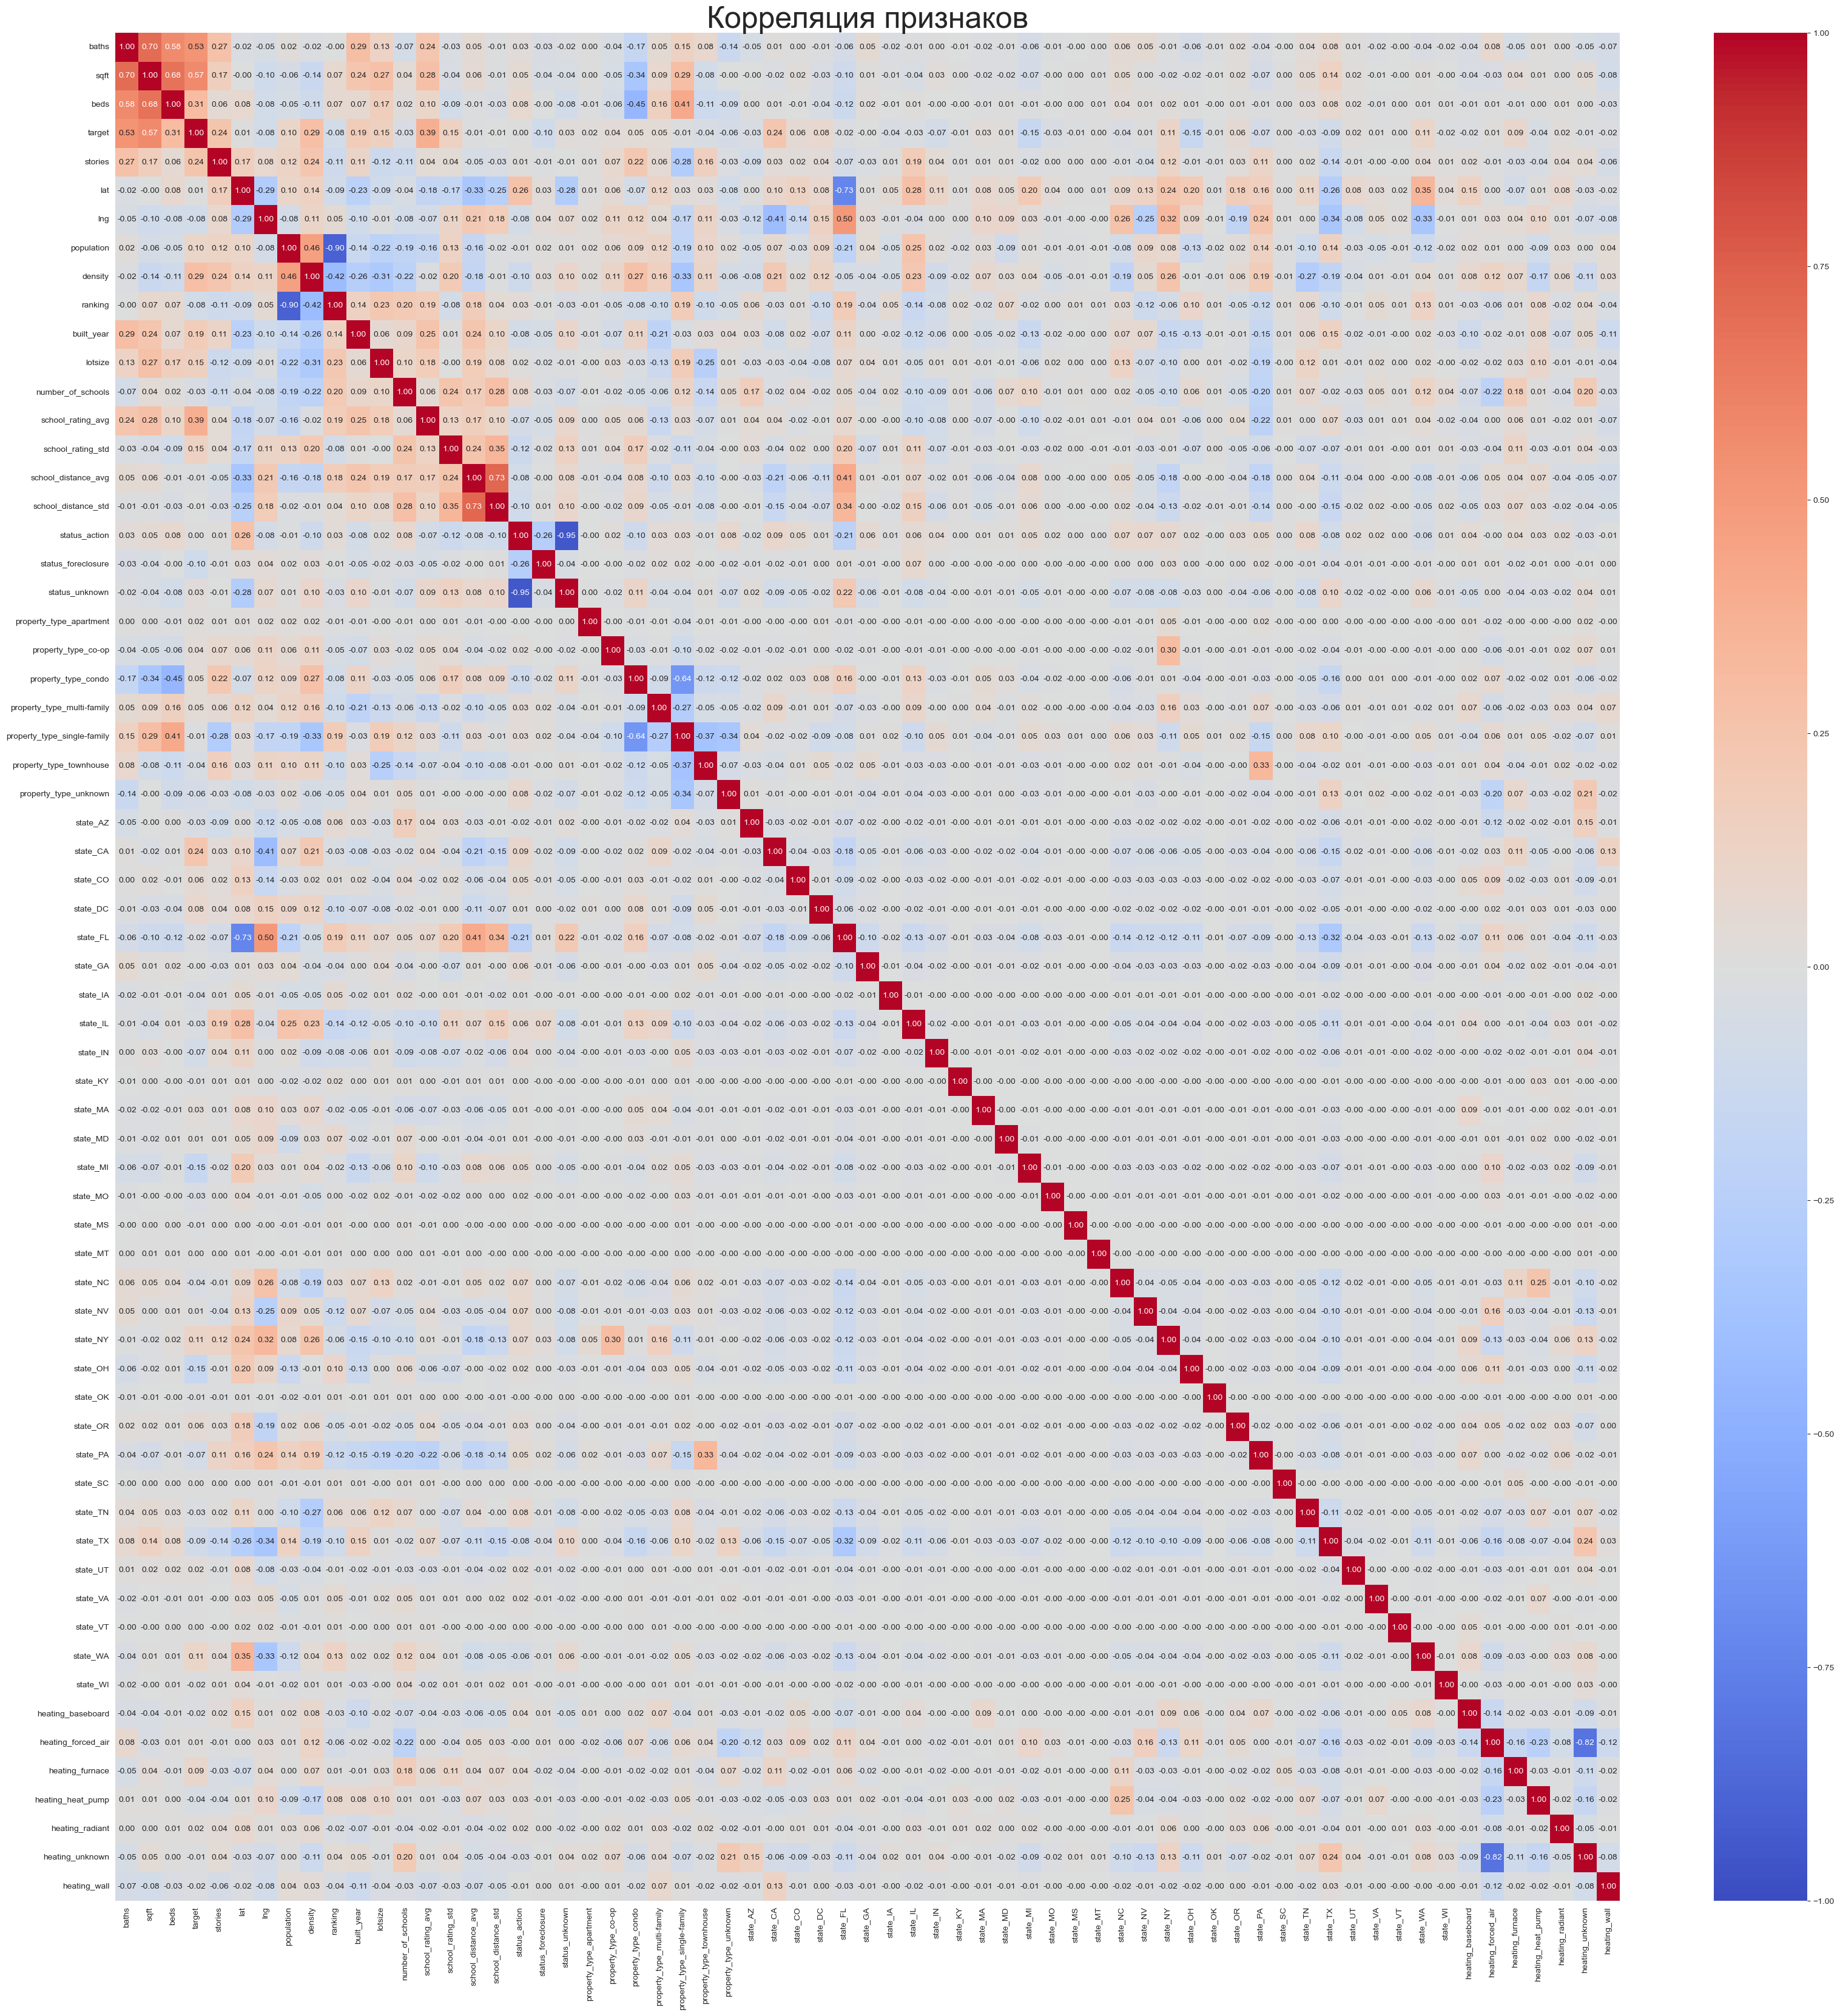

In [158]:
fig = plt.figure(figsize=(40, 40))
plt.title('Корреляция признаков', fontsize=36)
sns.heatmap(train.corr('spearman'), cmap='coolwarm', vmin=-1, vmax=1, annot=True, fmt='.2f');

Разглядеть что-то здесь практически невозможно, однако я сообщаю, что крайне высоким уровней корреляции (0.9 по модулю и выше) обладают только две пары признаков:
1. "status_action" - "status_unknown" (0.95);
2. "population" - "ranking" (0.90).

Предлагаю удалить признаки "ranking" и "status_action", так как они имеют наименьшую корреляцию с целевым признаком.

In [159]:
train = train.drop(columns=['ranking', 'status_action'])
val = val.drop(columns=['ranking', 'status_action'])
test = test.drop(columns=['ranking', 'status_action'])

Осталось только масштабировать данные и предобработка будет закончена.

In [160]:
# разделим данные на X и y
X_train = train.drop(columns='target')
y_train = train['target']

X_val = val.drop(columns='target')
y_val = val['target']

X_test = test.drop(columns='target')
y_test = test['target']

# масштабируем данные
mm_scaler = MinMaxScaler()
mm_scaler.fit(X_train)
X_train = mm_scaler.transform(X_train)
X_val = mm_scaler.transform(X_val)
X_test = mm_scaler.transform(X_test)

## 2.2. Построение и обучение модели.

### 2.2.1. Линейная/полиномиальная регрессия.

Для начала опробуем простую линейную регрессию.

In [161]:
# создаем и обучаем модель
lr = LinearRegression()
lr.fit(X_train, y_train)

# делаем предсказания
y_train_pred = lr.predict(X_train)
y_val_pred = lr.predict(X_val)

# выводим результат
print(f'Train MAE: {np.round(mean_absolute_error(y_train, y_train_pred), 3)}')
print(f'Train MAPE: {np.round(mean_absolute_percentage_error(y_train, y_train_pred), 3)}')
print(f'Train R2: {np.round(r2_score(y_train, y_train_pred), 3)}')
print()
print(f'Validate MAE: {np.round(mean_absolute_error(y_val, y_val_pred), 3)}')
print(f'Validate MAPE: {np.round(mean_absolute_percentage_error(y_val, y_val_pred), 3)}')
print(f'Validate R2: {np.round(r2_score(y_val, y_val_pred), 3)}')

Train MAE: 414081.313
Train MAPE: 1.151
Train R2: 0.327

Validate MAE: 467410.501
Validate MAPE: 1.177
Validate R2: 0.242


Как мы видим, модель страшно недообучена. Попробуем полиномиальную регрессию.

In [162]:
# создаем и обучаем модель
pipe = Pipeline([('poly', PolynomialFeatures(2)),
                 ('model', LinearRegression())])
pipe.fit(X_train, y_train)

# делаем предсказания
y_train_pred = pipe.predict(X_train)
y_val_pred = pipe.predict(X_val)

# выводим результат
print(f'Train MAE: {np.round(mean_absolute_error(y_train, y_train_pred), 3)}')
print(f'Train MAPE: {np.round(mean_absolute_percentage_error(y_train, y_train_pred), 3)}')
print(f'Train R2: {np.round(r2_score(y_train, y_train_pred), 3)}')
print()
print(f'Validate MAE: {np.round(mean_absolute_error(y_val, y_val_pred), 3)}')
print(f'Validate MAPE: {np.round(mean_absolute_percentage_error(y_val, y_val_pred), 3)}')
print(f'Validate R2: {np.round(r2_score(y_val, y_val_pred), 3)}')

Train MAE: 294300.589
Train MAPE: 0.733
Train R2: 0.65

Validate MAE: 249944963365980.16
Validate MAPE: 2106595664.625
Validate R2: -6.153681964041465e+19


Думаю, результаты говорят сами за себя.

Попробуем исправить ситуацию с помощью регуляризации (параметр регуляризации подобран вручную).

In [167]:
# создаем и обучаем модель
pipe = Pipeline([('poly', PolynomialFeatures(2)),
                 ('model', Ridge(alpha=0.1, random_state=42))])
pipe.fit(X_train, y_train)

# делаем предсказания
y_train_pred = pipe.predict(X_train)
y_val_pred = pipe.predict(X_val)

# выводим результат
print(f'Train MAE: {np.round(mean_absolute_error(y_train, y_train_pred), 3)}')
print(f'Train MAPE: {np.round(mean_absolute_percentage_error(y_train, y_train_pred), 3)}')
print(f'Train R2: {np.round(r2_score(y_train, y_train_pred), 3)}')
print()
print(f'Validate MAE: {np.round(mean_absolute_error(y_val, y_val_pred), 3)}')
print(f'Validate MAPE: {np.round(mean_absolute_percentage_error(y_val, y_val_pred), 3)}')
print(f'Validate R2: {np.round(r2_score(y_val, y_val_pred), 3)}')

Train MAE: 308717.751
Train MAPE: 0.758
Train R2: 0.617

Validate MAE: 350633.066
Validate MAPE: 0.776
Validate R2: 0.504


Также опробуем L1-регуляризацию.

In [171]:
# создаем и обучаем модель
pipe = Pipeline([('poly', PolynomialFeatures(2)),
                 ('model', Lasso(alpha=100, random_state=42))])
pipe.fit(X_train, y_train)

# делаем предсказания
y_train_pred = pipe.predict(X_train)
y_val_pred = pipe.predict(X_val)

# выводим результат
print(f'Train MAE: {np.round(mean_absolute_error(y_train, y_train_pred), 3)}')
print(f'Train MAPE: {np.round(mean_absolute_percentage_error(y_train, y_train_pred), 3)}')
print(f'Train R2: {np.round(r2_score(y_train, y_train_pred), 3)}')
print()
print(f'Validate MAE: {np.round(mean_absolute_error(y_val, y_val_pred), 3)}')
print(f'Validate MAPE: {np.round(mean_absolute_percentage_error(y_val, y_val_pred), 3)}')
print(f'Validate R2: {np.round(r2_score(y_val, y_val_pred), 3)}')

C:\Users\drull\anaconda3\envs\python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.246e+15, tolerance: 2.426e+13



Train MAE: 318586.267
Train MAPE: 0.751
Train R2: 0.578

Validate MAE: 358660.24
Validate MAPE: 0.763
Validate R2: 0.515


Lasso-регуляризация справилась с задачей чуть лучше, однако модель все еще недообучена.

Обучать модель на признаках 3-й степени мы не будем, так как для этого у нас не хватит оперативной памяти.

Перейдем к регрессии методом k-ближайших соседей.

### 2.2.2. Регрессия методом k-ближайших соседей.

Оптимизацию гиперпараметров будем производить при помощи библиотеки optuna. Будем максимизировать метрику $R^2$.

In [172]:
def optuna_knn(trial):
    # задаем сетку параметров
    n_neighbors = trial.suggest_int('n_neighbors', 3, 29, 2)
    leaf_size = trial.suggest_int('leaf_size', 10, 200, 10)
    p = trial.suggest_int('p', 1, 2)
    
    # создаем и обучаем модель
    knn = KNeighborsRegressor(
        n_neighbors=n_neighbors,
        leaf_size=leaf_size,
        p=p,
        n_jobs=-1)
    
    knn.fit(X_train, y_train)
    
    # делаем прогноз
    y_val_pred = knn.predict(X_val)
    
    # вычисляем метрику
    score = r2_score(y_val, y_val_pred)

    return score

# используем optuna
study = optuna.create_study(study_name="KNNRegressor", direction="maximize")
study.optimize(optuna_knn, n_trials=50)

# выводим лучшие значения гиперпараметров
best_params = study.best_params
print(f'Наилучшие значения гиперпараметров {best_params}')

Наилучшие значения гиперпараметров {'n_neighbors': 3, 'leaf_size': 190, 'p': 1}


In [174]:
# создаем и обучаем модель
knn = KNeighborsRegressor(n_neighbors=3, leaf_size=190, p=1, n_jobs=-1)
knn.fit(X_train, y_train)

# делаем предсказания
y_train_pred = knn.predict(X_train)
y_val_pred = knn.predict(X_val)

# выводим результат
print(f'Train MAE: {np.round(mean_absolute_error(y_train, y_train_pred), 3)}')
print(f'Train MAPE: {np.round(mean_absolute_percentage_error(y_train, y_train_pred), 3)}')
print(f'Train R2: {np.round(r2_score(y_train, y_train_pred), 3)}')
print()
print(f'Validate MAE: {np.round(mean_absolute_error(y_val, y_val_pred), 3)}')
print(f'Validate MAPE: {np.round(mean_absolute_percentage_error(y_val, y_val_pred), 3)}')
print(f'Validate R2: {np.round(r2_score(y_val, y_val_pred), 3)}')

Train MAE: 160768.56
Train MAPE: 0.25
Train R2: 0.804

Validate MAE: 282477.215
Validate MAPE: 0.383
Validate R2: 0.418


Модель k-ближайших соседей выдает значительно лучшие значения метрик MAE и MAPE, однако значение метрики $R^2$ ниже.

Перейдем к последней модели.

### 2.2.3. Экстремальный градиентный бустинг.

Подбор гиперпараметров также будем производить с помощью библиотеки optuna. Параметру "n_estimators" присвоено значение 200, чтобы сильно не затягивать процесс оптимизации. Потом мы увелияим это значение до 2000.

In [175]:
def optuna_xgboost(trial):
    # задаем сетку параметров
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.5, step=0.01)
    max_depth = trial.suggest_int('max_depth', 1, 10)
    reg = trial.suggest_categorical('reg', ['l1', 'l2', 'none'])
    if reg == 'l1':
        reg_alpha = 10 ** trial.suggest_int('reg_alpha', -2, 3)
        reg_lambda = 0
    elif reg == 'l2':
        reg_alpha = 0
        reg_lambda = 10 ** trial.suggest_int('reg_lambda', -2, 3)
    else:
        reg_alpha = 0
        reg_lambda = 0
    
    # создаем и обучаем модель
    xgb = XGBRegressor(
        n_estimators=200,
        learning_rate=learning_rate,
        max_depth=max_depth,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        n_jobs=-1,
        random_state=42)
    
    xgb.fit(X_train, y_train)
    
    # делаем прогноз
    y_val_pred = xgb.predict(X_val)
    
    # вычисляем метрику
    score = r2_score(y_val, y_val_pred)

    return score

study = optuna.create_study(study_name="XGBRegressor", direction="maximize")
study.optimize(optuna_xgboost, n_trials=50)

best_params = study.best_params
print(f'Наилучшие значения гиперпараметров {best_params}')

Наилучшие значения гиперпараметров {'learning_rate': 0.24000000000000002, 'max_depth': 7, 'reg': 'l2', 'reg_lambda': -2}


In [176]:
# создаем и обучаем модель
xgb = XGBRegressor(n_estimators=2000, learning_rate=0.24, max_depth=7,
                   reg_alpha=0, reg_lambda=0.01, random_state=42, n_jobs=-1)

xgb.fit(X_train, y_train)

# делаем предсказания
y_train_pred = xgb.predict(X_train)
y_val_pred = xgb.predict(X_val)

# выводим результат
print(f'Train MAE: {np.round(mean_absolute_error(y_train, y_train_pred), 3)}')
print(f'Train MAPE: {np.round(mean_absolute_percentage_error(y_train, y_train_pred), 3)}')
print(f'Train R2: {np.round(r2_score(y_train, y_train_pred), 3)}')
print()
print(f'Validate MAE: {np.round(mean_absolute_error(y_val, y_val_pred), 3)}')
print(f'Validate MAPE: {np.round(mean_absolute_percentage_error(y_val, y_val_pred), 3)}')
print(f'Validate R2: {np.round(r2_score(y_val, y_val_pred), 3)}')

Train MAE: 29053.208
Train MAPE: 0.101
Train R2: 0.999

Validate MAE: 193892.761
Validate MAPE: 0.286
Validate R2: 0.769


Эта модель показывает куда лучшие результаты по всем метрикам (хотя и имеет признаки переобучения). Именно на этой модели мы и остановим свой выбор.

Однако сейчас я предлагаю воспользоваться особенностями модолей, основанными на деревьях решений, и заняться отбором признаков на основе модели.

Ради интереса посмотрим на то, какие признаки оказывают на модель наибольшее влияние.

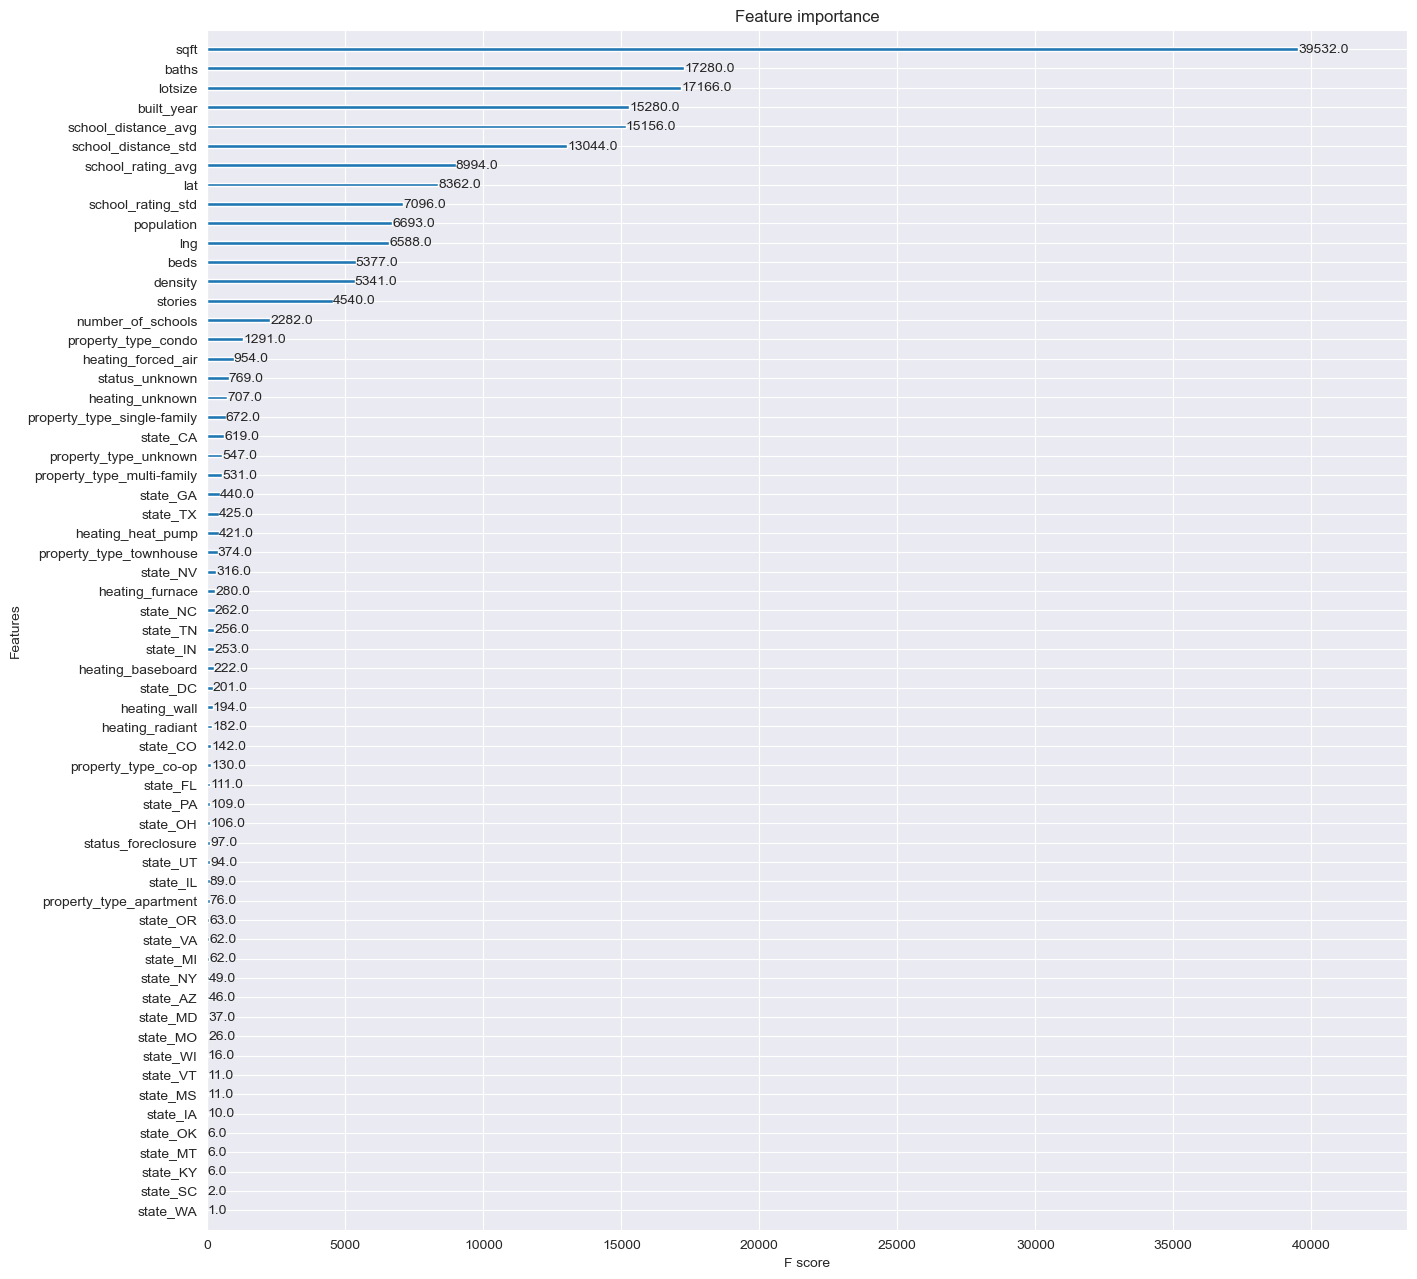

In [178]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_axes([0, 0, 1, 1])
plot_importance(xgb, ax=ax);

Впереди с огромным отрывом идет признак жилой площади, на удивление большой вклад производят признаки, связанные со школами. Однако видно, что как минимум половину признаков мы можем спокойно удалить (куда войдут практически все признаки, указывающие на штат).

Убираем признаки встроенным методом

In [179]:
fs = SelectFromModel(xgb, prefit=True, threshold='median')
X_train_fs = fs.transform(X_train)
X_val_fs = fs.transform(X_val)
X_test_fs = fs.transform(X_test)

C:\Users\drull\anaconda3\envs\python311\Lib\site-packages\sklearn\base.py:457: UserWarning:

X has feature names, but SelectFromModel was fitted without feature names



Обучим модель на отобранных признаках и посмотрим на результаты.

In [180]:
# создаем и обучаем модель
xgb_fs = XGBRegressor(n_estimators=2000, learning_rate=0.24, max_depth=7,
                      reg_alpha=0, reg_lambda=0.01, random_state=42, n_jobs=-1)

xgb_fs.fit(X_train_fs, y_train)

# делаем предсказания
y_train_pred = xgb_fs.predict(X_train_fs)
y_val_pred = xgb_fs.predict(X_val_fs)

# выводим результат
print(f'Train MAE: {np.round(mean_absolute_error(y_train, y_train_pred), 3)}')
print(f'Train MAPE: {np.round(mean_absolute_percentage_error(y_train, y_train_pred), 3)}')
print(f'Train R2: {np.round(r2_score(y_train, y_train_pred), 3)}')
print()
print(f'Validate MAE: {np.round(mean_absolute_error(y_val, y_val_pred), 3)}')
print(f'Validate MAPE: {np.round(mean_absolute_percentage_error(y_val, y_val_pred), 3)}')
print(f'Validate R2: {np.round(r2_score(y_val, y_val_pred), 3)}')

Train MAE: 29123.813
Train MAPE: 0.101
Train R2: 0.999

Validate MAE: 194351.488
Validate MAPE: 0.29
Validate R2: 0.765


Замечательно! Мы сократили количество признаков вдвое, а результат почти не изменился.

## 2.3. Оценка и сериализация модели.

Посмотрим, как наша модель работает на тестовой выборке.

In [181]:
y_test_pred = xgb_fs.predict(X_test_fs)
print(f'Validate MAE: {np.round(mean_absolute_error(y_test, y_test_pred), 3)}')
print(f'Validate MAPE: {np.round(mean_absolute_percentage_error(y_test, y_test_pred), 3)}')
print(f'Validate R2: {np.round(r2_score(y_test, y_test_pred), 3)}')

Validate MAE: 188639.75
Validate MAPE: 0.295
Validate R2: 0.749


Мы видим, что значения метрик MAPE и $R^2$ слегка ухудшились (что и не удивительно, результаты на тестовом наборе обычно хуже, чем на валидационном), а вот метрика MAE показывает, на удивление, лучший результат.

Я предлагаю повнимательнее посмотреть на то, где именно наша модель делает ошибки. Составим датафрейм с реальными значениями целевого признака тестовой выборки, с предсказанными значениями, а также с абсолютной и процентной ошибкой по каждой паре.

In [182]:
results = pd.DataFrame(
    {'test': y_test,
    'pred': y_test_pred,
    'AE':np.abs(y_test_pred - y_test),
    'APE': np.abs(y_test_pred - y_test) / y_test})

results

,test,pred,AE,APE
177189,388000.0,3.566648e+05,31335.218750,0.080761
4633,195000.0,2.401700e+05,45170.015625,0.231641
159885,1198888.0,1.511218e+06,312329.750000,0.260516
104763,1225000.0,8.847493e+05,340250.687500,0.277756
132350,343990.0,4.225821e+05,78592.125000,0.228472
...,...,...,...,...
30498,897000.0,8.698267e+05,27173.312500,0.030294
62485,299900.0,3.081148e+05,8214.843750,0.027392
52779,750000.0,5.249196e+05,225080.375000,0.300107
6983,875000.0,9.018171e+05,26817.062500,0.030648


In [183]:
results.describe()

,test,pred,AE,APE
count,1.552300e+04,1.552300e+04,1.552300e+04,15523.000000
mean,6.559431e+05,6.473272e+05,1.886398e+05,0.294958
std,1.694890e+06,1.373670e+06,8.278596e+05,0.672153
min,5.900000e+03,-3.867565e+05,4.140625e+00,0.000025
25%,2.099000e+05,2.153784e+05,2.175305e+04,0.073303
50%,3.399000e+05,3.475040e+05,5.318878e+04,0.162905
75%,5.899000e+05,6.097321e+05,1.291721e+05,0.323758
max,6.500000e+07,6.536437e+07,4.854245e+07,37.028422


Видно, что медианная процентная ошика нашей модели составляет всего 0.16, ошибка 75-го перцентиля не сильно отличается от средней, однако максимальная ошибка просто колоссальна.

In [185]:
results[results['APE'] > 1]

,test,pred,AE,APE
22161,288800.0,627532.937500,338732.937500,1.172898
176176,411270.0,861223.625000,449953.625000,1.094059
103124,99900.0,319592.437500,219692.437500,2.199123
115874,159900.0,351674.468750,191774.468750,1.199340
109153,125000.0,401552.562500,276552.562500,2.212420
...,...,...,...,...
179699,399000.0,867594.625000,468594.625000,1.174423
126095,219900.0,452717.562500,232817.562500,1.058743
180775,142900.0,350256.843750,207356.843750,1.451063
114694,19900.0,97686.703125,77786.703125,3.908880


Видно, что в 640 случаях (что составляет примерно 4% тестовой выборки) модель ошибается более чем в 2 раза.

Посмотрим на распределение ошибок по ценовым диапазонам.

In [188]:
bins = np.geomspace(1000, 100000000, 6)
results['bins'] = pd.cut(results['test'], bins)
results.groupby('bins').mean()

,test,pred,AE,APE
bins,,,,
"(1000.0, 10000.0]",8.266333e+03,-4.222646e+04,9.515232e+04,14.609597
"(10000.0, 100000.0]",6.672195e+04,1.052484e+05,5.305742e+04,0.946961
"(100000.0, 1000000.0]",3.780891e+05,4.041017e+05,8.875775e+04,0.241135
"(1000000.0, 10000000.0]",2.293179e+06,2.269658e+06,6.994821e+05,0.287556
"(10000000.0, 100000000.0]",1.930378e+07,1.286587e+07,7.670803e+06,0.394440


In [189]:
results.groupby('bins').median()

,test,pred,AE,APE
bins,,,,
"(1000.0, 10000.0]",8999.0,1.233874e+04,6.364955e+04,6.429247
"(10000.0, 100000.0]",69900.0,8.998298e+04,3.117784e+04,0.482729
"(100000.0, 1000000.0]",325000.0,3.309995e+05,4.671109e+04,0.149083
"(1000000.0, 10000000.0]",1698900.0,1.647010e+06,3.577435e+05,0.201053
"(10000000.0, 100000000.0]",15750000.0,1.111034e+07,6.967575e+06,0.395610


Итак, мы видим, что лучше всего наша модель справляется с диапазоном цен от 100 тыс. до 1 млн., также очень неплохо работает в диапазоне от 1 млн. до 10 млн., однако все, что выходит за эти рамки, вызывает у нашей модели большие трудности. Почему?

In [193]:
df['bins'] = pd.cut(df['target'], bins)
(df.groupby('bins')['target'].count() / df.shape[0]) * 100

bins
(1000.0, 10000.0]             0.016106
(10000.0, 100000.0]           6.680754
(100000.0, 1000000.0]        81.713932
(1000000.0, 10000000.0]      11.165943
(10000000.0, 100000000.0]     0.423265
Name: target, dtype: float64

Потому что практически все значения цены в нашем датасете расположены в диапазоне от 100 тыс. до 1 млн., почти 94% в диапазоне от 100 тыс. до 10 млн. Объекты недвижимости из других ценовых диапазонов, скорее всего, служат выбросами и искажают работу нашей модели. Вероятно, сократив диапазон цен в пределах 100 тыс. - 10 млн., мы смогли бы сильно повысить метрики, однако такая модель будет непригодна для работы в других ценовых категориях. Впрочем, она и сейчас для этого непригодна, так что, вероятно, имело бы смысл переобучить модель и сопроводить ее указанием: использовать только от сих до сих. Для работы же с другими ценовыми категориями нам не хватает данных. Но мы это оставим.

Осталось только сериализовать нашу модель.

In [205]:
joblib.dump(xgb_fs, 'model.joblib')

['model.joblib']

# Заключение.

Что я могу сказать по итогам выполнения работы? Точнее, чтобы я мог предложить, если бы встретился с такой задачей на практике.

1. Первое дело - оторвать руки человеку, ответственному за сбор и хранение данных. Честно признаюсь, первое, что бы я сделал, увидев такую таблицу, - пошел бы жаловаться начальству. Данные, материал - это основа нашей работы. Когда Микеланджело Буонарроти спросили, как он создал своего божественного Давида, тот ответил:"Я взял глыбу мрамора и отсек от нее все лишнее" - однако вряд ли Микеланджело, при всей его гениальности, смог бы отсечь все лишнее у кучи навоза, а данный датасет - натуральные авгиевы конюшни. Кстати, я где-то читал (кажется, у Гвидо и Мюллера), что на чистых данных все модели машинного обучения выдают практически идентичные результаты - занимательный факт.
2. Организовать дополнительный сбор данных.
3. Рассмотреть возможность построения нескольких моделей для разных классов объектов недвижимости: жилье на продажу, жилье в аренду, земельные участки. Возможно, также стоит отдельно рассматривать кооперативы и кондоминиумы (так как в этих случаях покупатель приобретает не всю собственность, а только часть, т.е. цена формируется несколько иначе).
4. Наконец, было бы очень здорово обработать адреса. Уверен, тем самым мы бы резко повысили качество модели.

На этом, пожалуй, все.